In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scvelo as scv

from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

sc.settings.cachedir = "/media/agando/578222DA06535F39/cache/"

In [2]:
adata = sc.read("../data/EpiHiRes.h5ad",
                cache = True)

### Figures S7 a to m

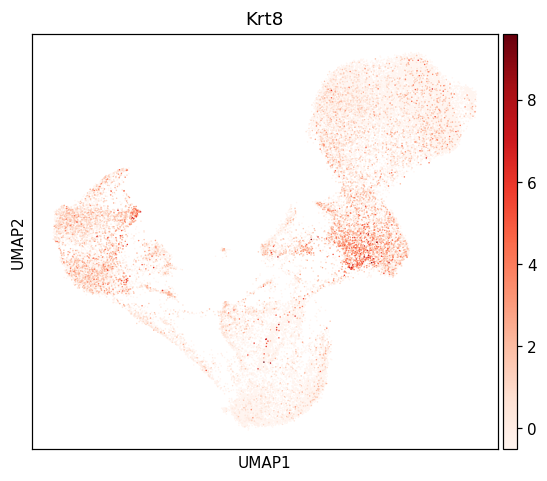

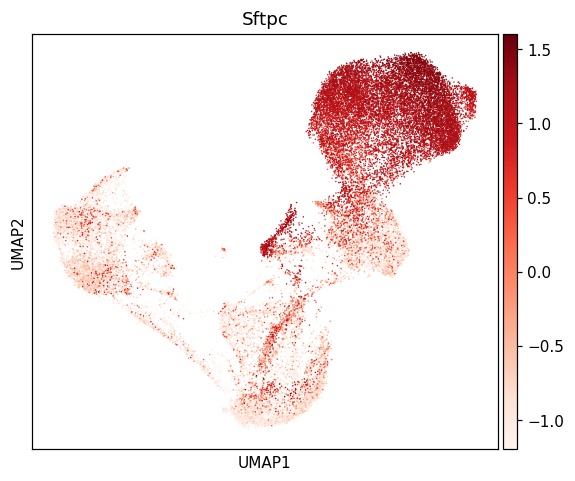

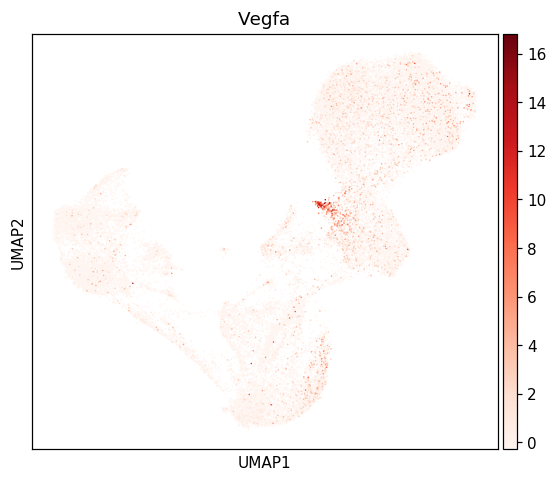

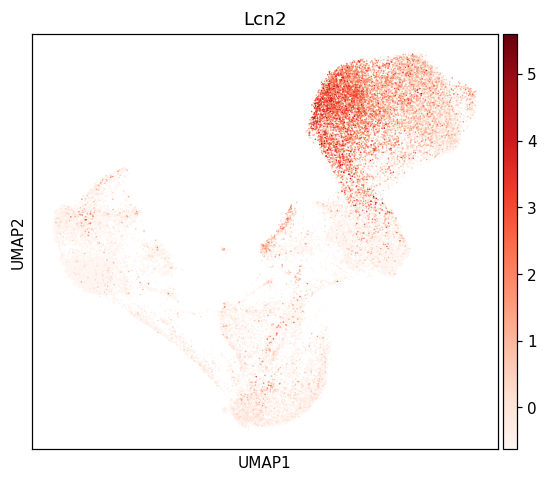

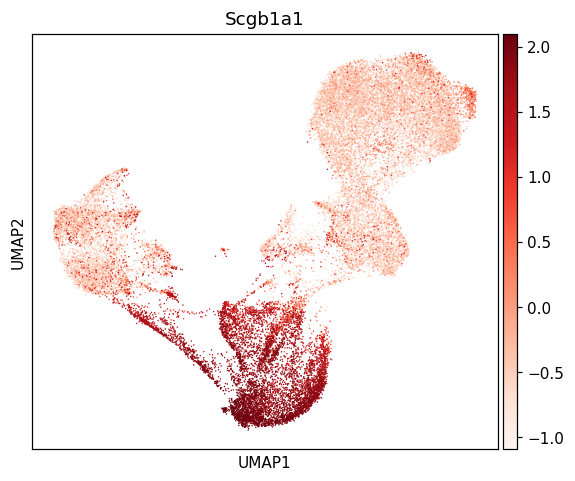

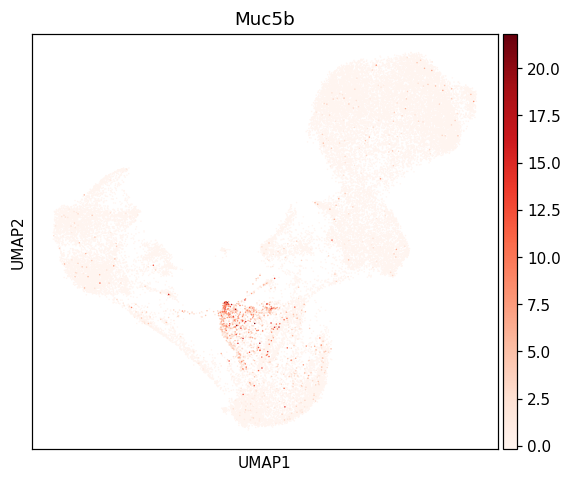

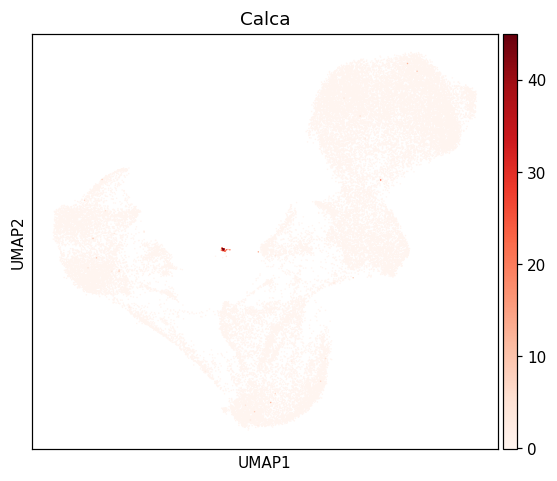

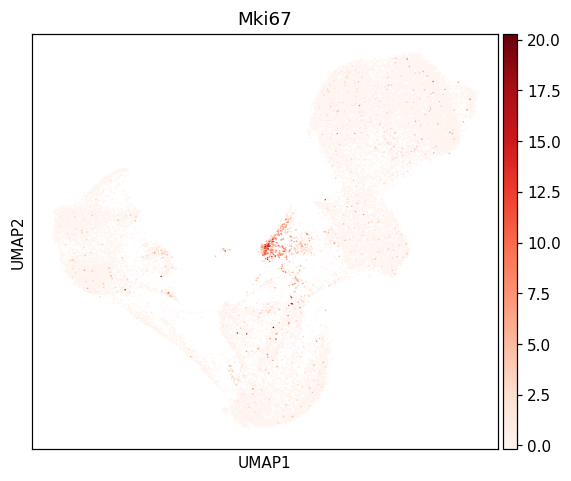

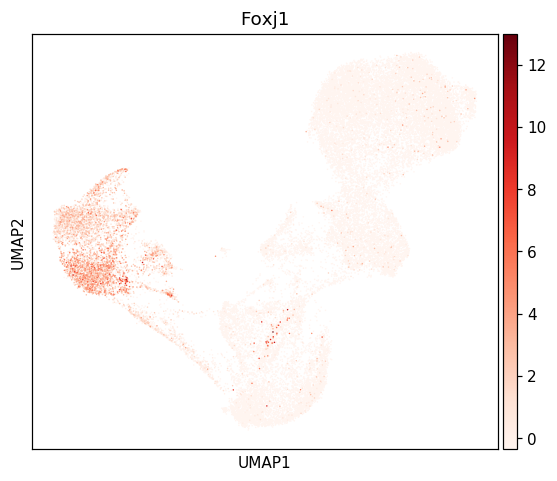

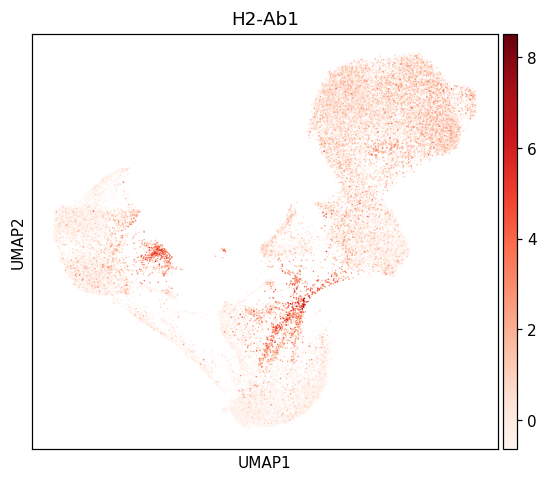

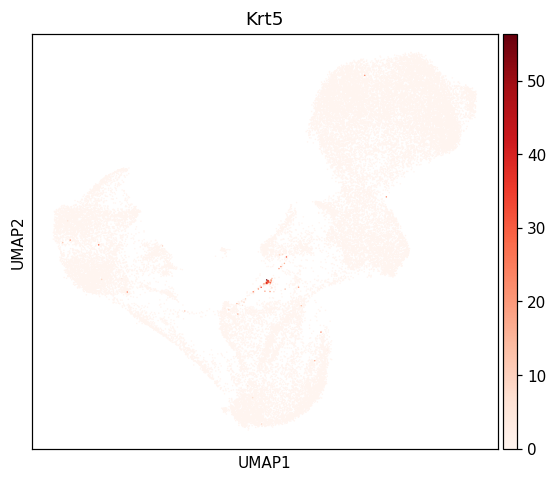

In [9]:
genes = ["Krt8", "Sftpc", "Vegfa", "Lcn2", "Scgb1a1", "Muc5b", "Calca", "Mki67", "Foxj1", "H2-Ab1", "Krt5"]
for gen in genes:
    sc.pl.umap(adata, color = gen, ax = plt.figure(figsize = (6, 5), dpi = 110).gca(), use_raw = False, cmap = mymap)

### Figure S7 n

In [3]:
## Function for manual scaling and averaging expression per cell type in Heatmap
## Adapted heatmap function from scanpy
from scanpy.plotting._anndata import _plot_categories_as_colorblocks, _prepare_dataframe
from scanpy.plotting._anndata import _reorder_categories_after_dendrogram, _check_var_names_type
from scanpy.plotting._anndata import _plot_dendrogram
from scanpy.plotting._anndata import _plot_categories_as_colorblocks, _plot_colorbar
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.stats import zscore

def avg_heatmap(adata, var_names, groupby = None, log = False, use_raw = False, num_categories = 7, order = None,
                gene_symbols = None, var_group_labels = None, var_group_positions = None, layer = None,
                show_gene_labels = None, scale = True, save = None, vmax = None, vmin = None, cmap = "viridis",
                dendrogram = True, colorbar_width = 0.2, categorical = True, figsize = (10, 5), ticksize = 10):

    categories, obs_tidy = _prepare_dataframe(adata, var_names, groupby, use_raw, log, num_categories,
                                                  gene_symbols = gene_symbols, layer = layer)
    var_group_labels = None
    var_group_positions = None
    var_names, var_group_labels, var_group_positions = _check_var_names_type(var_names,
                                                                             var_group_labels, var_group_positions)
    ## Inserted for mean per Cluster
    obs_means = obs_tidy.groupby(groupby).mean()
    
    if scale == True:
        for x in obs_means.columns:
            obs_means[x] = (obs_means[x] - obs_means[x].mean()) / obs_means[x].std()
        
    # get categories colors:
    groupby_colors = adata.uns[groupby + "_colors"]

    # obs_tidy = obs_tidy.sort_index()
    if order is not None:
        obs_means.index = obs_means.index.reorder_categories(order)
    else:
        obs_means = obs_means.sort_index()


    if show_gene_labels is None:
        if len(var_names) <= 50:
            show_gene_labels = True
        else:
            show_gene_labels = False
            #logg.warning(
            print('Gene labels are not shown when more than 50 genes are visualized. '
                 'To show gene labels set `show_gene_labels=True`')

    dendro_height = 0
    groupby_height = 0.13 if categorical else 0
    if figsize is None:
        if show_gene_labels:
            heatmap_height = len(var_names) * 0.18
        else:
            heatmap_height = 4
        width = 10
        height = heatmap_height + dendro_height + groupby_height  # +2 to account for labels
    else:
        width, height = figsize
        heatmap_height = height - (dendro_height + groupby_height)

    height_ratios = [dendro_height, heatmap_height, groupby_height]

    if var_group_positions is not None and len(var_group_positions) > 0:
        # add some space in case 'brackets' want to be plotted on top of the image
        width_ratios = [width, 0.14, colorbar_width]
    else:
        width_ratios = [width, 0, colorbar_width]

    fig = plt.figure(figsize=(width, height))
    axs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.25 / width,
                            hspace=0.3 / height,
                            width_ratios=width_ratios,
                            height_ratios=height_ratios)

    # plot heatmap
    heatmap_ax = fig.add_subplot(axs[1, 0])

    if order is not None:
        obs_means = obs_means.reindex(order, axis = 0)
    
    im = heatmap_ax.imshow(obs_means.T.values, aspect = 'auto', cmap = cmap, 
                           vmin = vmin, vmax = vmax)#, **kwds)              ## adapted for mean
    heatmap_ax.set_xlim(-0.5, obs_means.shape[0] - 0.5)                     ## adapted for mean
    heatmap_ax.set_ylim(obs_means.shape[1] - 0.5, - 0.5)                    ## adapted for mean

    heatmap_ax.tick_params(axis='x', bottom=False, labelbottom=False)
    heatmap_ax.set_xlabel('')
    heatmap_ax.grid(False)
    if show_gene_labels:
        heatmap_ax.tick_params(axis='y', labelsize='small', length = 1)
        heatmap_ax.set_yticks(np.arange(len(var_names)))
        heatmap_ax.set_yticklabels(var_names, rotation=0, size = ticksize)
        heatmap_ax.set
    else:
        heatmap_ax.tick_params(axis='y', labelleft=False, left=False)

    if categorical:
        groupby_ax = fig.add_subplot(axs[2, 0])
        groupby = obs_means.index.name
        groupby_cmap = ListedColormap(groupby_colors, groupby + '_cmap')
        norm = BoundaryNorm(np.arange(groupby_cmap.N+1)-.5, groupby_cmap.N)

        # determine groupby label positions such that they appear
        # centered next/below to the color code rectangle assigned to the category
        value_sum = -0.5  ## changed from 0
        ticks = []  # list of centered position of the labels
        labels = []
        label2code = {}  # dictionary of numerical values asigned to each label

        for code, (label, value) in enumerate(obs_means.index.value_counts(sort = False).iteritems()):
        
            ticks.append(value_sum + (value / 2))
            labels.append(label)
            value_sum += value
            label2code[label] = code
        groupby_ax.grid(False)

        groupby_ax.imshow(np.matrix([label2code[lab] for lab in obs_means.index]), aspect='auto', 
                          cmap = groupby_cmap, norm = norm)
        if len(labels) > 1:
            groupby_ax.set_xticks(ticks)
            if max([len(x) for x in labels]) < 3:
                # if the labels are small do not rotate them
                rotation = 0
            else:
                rotation = 90
            groupby_ax.set_xticklabels(labels, rotation=rotation)

        # remove x ticks, y ticks and labels
        groupby_ax.tick_params(axis='x', bottom = False, labelsize = ticksize)
        groupby_ax.tick_params(axis='y', left = False, labelleft = False)

        # remove surrounding lines
        groupby_ax.spines['right'].set_visible(False)
        groupby_ax.spines['top'].set_visible(False)
        groupby_ax.spines['left'].set_visible(False)
        groupby_ax.spines['bottom'].set_visible(False)

        groupby_ax.set_xlabel(groupby)

        # add lines to main heatmap
        line_positions = np.cumsum(obs_means.index.value_counts(sort=False))[:-1]
        heatmap_ax.vlines(line_positions - 0.505, -1, len(var_names) + 1, lw = 1)
    

    # plot colorbar
    _plot_colorbar(im, fig, axs[1, 2])
    
    plt.show()
    plt.close()


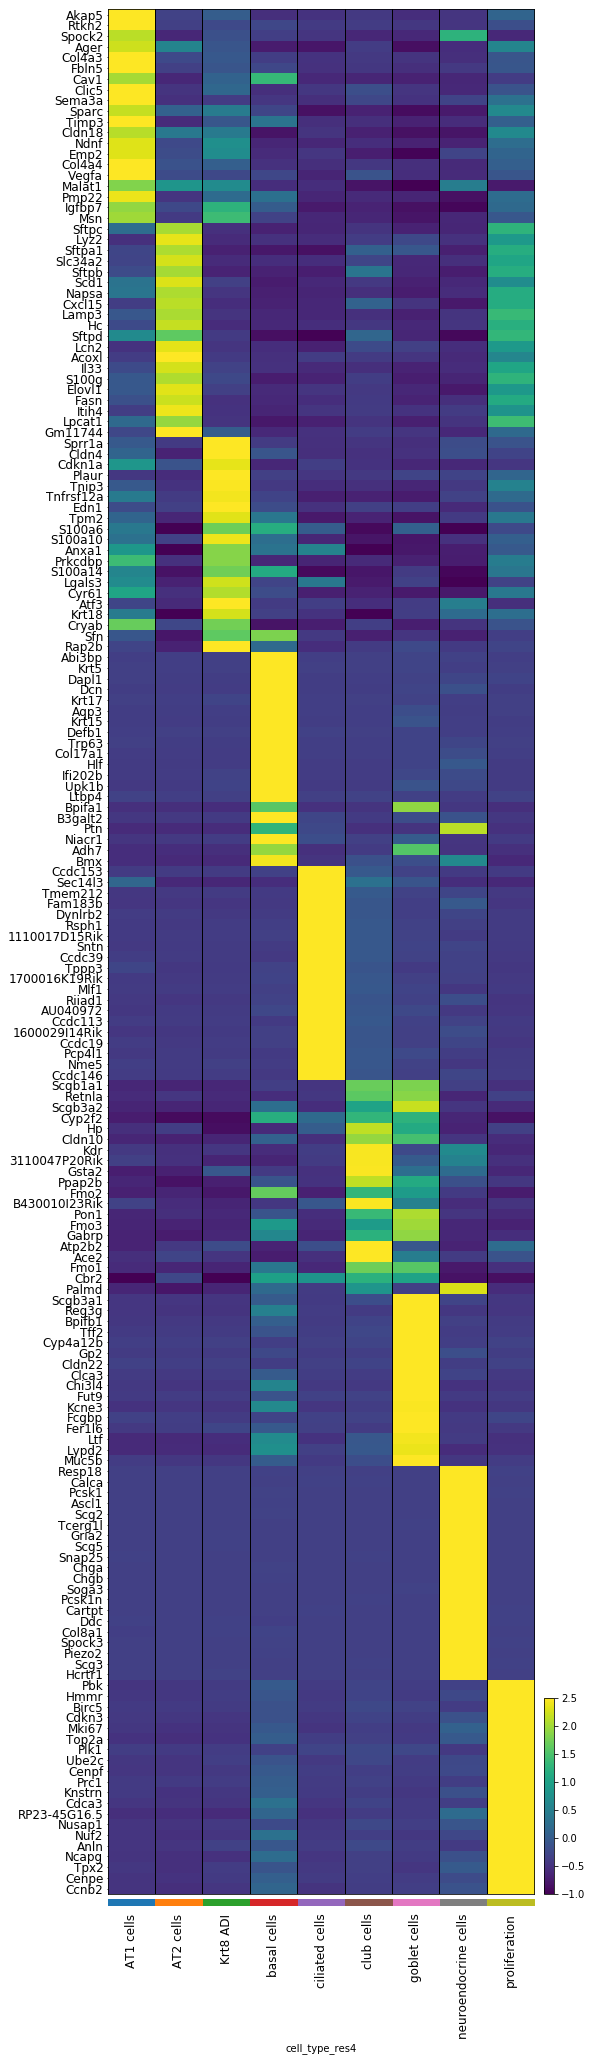

In [4]:
## Read in Excel Sheet with cell type and select top 20 genes for each cluster
folder = "/home/agando/Documents/Meshal/PhD_Scripts/short_scripts/Bleo_highRes/Epithel/Data/diff_gene_expr/"
marker = pd.read_excel(folder + "epi7_raw_AllMarkers.xlsx", sheet_name = "cell_types", index_col = 0)
marker.sort_values(by = ["cluster", "logfoldchange"], ascending = [True, False], inplace = True)

genes = []
for typ in np.unique(marker.cluster):
    curgenes = marker.loc[marker.cluster == typ, "gene"].values[0:20]
    genes = genes + [g for g in curgenes if g not in genes]

avg_heatmap(adata, var_names = genes, groupby = "cell_type_res4", ticksize = 12, figsize = (8, 35), 
            scale = True, use_raw = True, show_gene_labels = True, vmax = 2.5, vmin = -1, cmap = "viridis")